# Time Series Prediction 

Import Libraries

In [319]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.utils import shuffle
import random

# Data Set

In [320]:
#import dataset
data1 = pd.read_csv("CCF.csv")
dc=data1[['Date','Adj Close']]
#bb=dc.pivot(index='Date', columns='Name', values='close').iloc[:,0:52].drop(['APTV','ALLE'], axis=1)
dc.head()

,Date,Adj Close
0,2016-05-02,54.128033
1,2016-05-03,53.556633
2,2016-05-04,53.053028
3,2016-05-05,53.333885
4,2016-05-06,53.576000


In [326]:
dc['date'] = dc.index
dc1 = dc[['date', 'Adj Close']] #only use the Adjusted close price
dc1.columns = ['date', 'StockPrice'] #rename it to stock price
dc2=dc1.drop('date', 1)

C:\Users\jamiu\Anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
dc2.shape

(1008, 1)

# Data Preprocessing

In [61]:
#Check that no missing values
dc2.isnull().sum(axis=1)

0       0
1       0
2       0
3       0
4       0
       ..
1003    0
1004    0
1005    0
1006    0
1007    0
Length: 1008, dtype: int64

Moving averages of time series S

Assume
MA5(t) = newcases5
MA10(t) = newcases10
MA20(t) = newcases20

In [140]:
newcases5 = []
for i in range(19, dc2.shape[0]-1):  
    gg= pd.DataFrame(np.matrix([ dc2.iloc[i-4]+ dc2.iloc[i-3] + dc2.iloc[i-2] + dc2.iloc[i-1] + dc2.iloc[i]]).flatten()) 
    newcases5.append(gg)
newcases5a=(pd.concat(newcases5)/5).reset_index(drop=True)

In [142]:
newcases10 = []
for i in range(19, dc2.shape[0]-1):  
    gg= pd.DataFrame(np.matrix([dc2.iloc[i-9]+dc2.iloc[i-8]+dc2.iloc[i-7]+ dc2.iloc[i-6]+dc2.iloc[i-5]+  
        dc2.iloc[i-4]+dc2.iloc[i-3]+dc2.iloc[i-2]+ dc2.iloc[i-1]+dc2.iloc[i]]).flatten())  
    newcases10.append(gg)
newcases10a=(pd.concat(newcases10)/10).reset_index(drop=True)

In [144]:
newcases20 = []
for i in range(19, dc2.shape[0]-1):  
    gg= pd.DataFrame(np.matrix([dc2.iloc[i-19]+dc2.iloc[i-18]+dc2.iloc[i-17]+ dc2.iloc[i-16]+dc2.iloc[i-15]+  
        dc2.iloc[i-14]+dc2.iloc[i-13]+dc2.iloc[i-12]+ dc2.iloc[i-11]+dc2.iloc[i-10]+ dc2.iloc[i-9]+dc2.iloc[i-8]+
        dc2.iloc[i-7]+ dc2.iloc[i-6]+dc2.iloc[i-5]+ dc2.iloc[i-4]+dc2.iloc[i-3]+dc2.iloc[i-2]+ dc2.iloc[i-1]+dc2.iloc[i]]).flatten())  
    newcases20.append(gg)
newcases20a=(pd.concat(newcases20)/20).reset_index(drop=True)

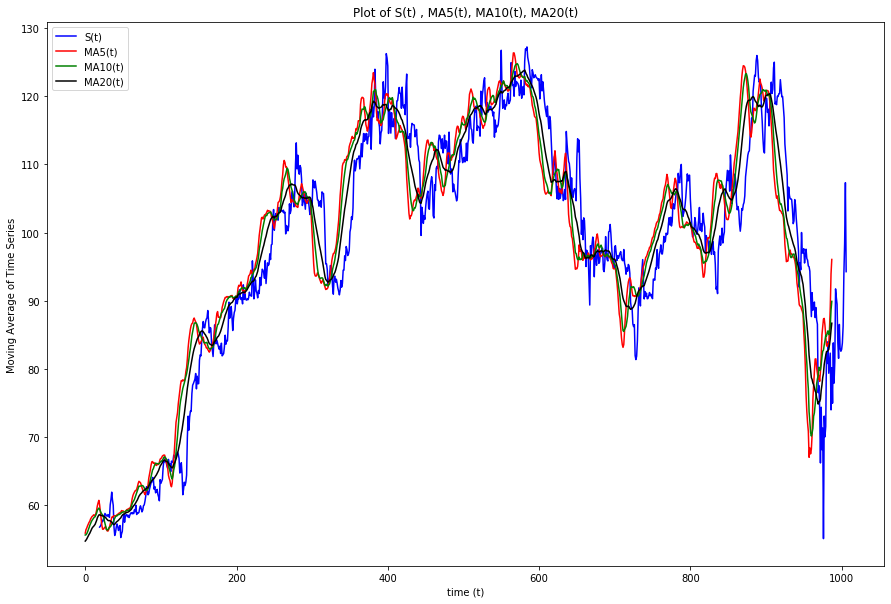

In [345]:
%matplotlib inline
plt.figure(figsize=(15, 10))
plt.figure(1)
plt.plot(dc2.iloc[19:dc2.shape[0]-1], color='b', label='S(t)')
plt.plot(newcases5a, color='r', label='MA5(t)')
plt.plot(newcases10a, color='g',label='MA10(t)' )
plt.plot(newcases20a,color='k', label='MA20(t)')
#plt.plot(MyMonitor.MSEtest, label='MSEtest', color='r')
#plt.legend(labels)
plt.ylabel('Moving Average of Time Series')
plt.xlabel('time (t)')
plt.title('Plot of S(t) , MA5(t), MA10(t), MA20(t)')
plt.legend( loc='upper left')

# Training and Test sets for an MLP predictor 

In [169]:
#Define St from 20 cases upward
dc3 = dc2.iloc[20:].reset_index(drop=True)#Define St from 20 cases upward
dc4 = dc2.iloc[21:].reset_index(drop=True) #output (target) result

In [346]:
dc3.shape

(988, 1)

Define the recent time series S (Vt)

In [347]:
#Training and Test sets for an MLP predictor :On each day t ≥ 20 , 
#the recent past of the series S will be defined as the 1x18 line vector
#Vt = [ MA5(t), MA10(t), MA20(t), S(t), S(t-1), S(t-2)..., S(t-13), S(t-14)]

newcasevt = []
for i in range(0, dc3.shape[0]-1):  
    gg= pd.DataFrame(np.matrix([newcases5a.iloc[i],newcases10a.iloc[i],newcases20a.iloc[i],dc3.iloc[i], dc3.iloc[i-1],
    dc3.iloc[i-2],dc3.iloc[i-3],dc3.iloc[i-4],dc3.iloc[i-5],dc3.iloc[i-6],dc3.iloc[i-7],dc3.iloc[i-8],dc3.iloc[i-9],
    dc3.iloc[i-10],dc3.iloc[i-11],dc3.iloc[i-12],dc3.iloc[i-13],dc3.iloc[i-14]]).flatten())
    newcasevt.append(gg)
newcasevt1=pd.concat(newcasevt).reset_index(drop=True)

In [349]:
newcasevt1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,55.859666,55.578809,54.689265,56.888184,96.709999,94.260002,107.330002,98.440002,94.000000,86.239998,83.779999,82.839996,82.570000,83.000000,86.510002,81.529999,83.800003,89.470001
1,56.386515,55.621422,54.827273,57.130306,56.888184,96.709999,94.260002,107.330002,98.440002,94.000000,86.239998,83.779999,82.839996,82.570000,83.000000,86.510002,81.529999,83.800003
2,56.605391,55.782189,55.005956,57.624226,57.130306,56.888184,96.709999,94.260002,107.330002,98.440002,94.000000,86.239998,83.779999,82.839996,82.570000,83.000000,86.510002,81.529999
3,56.923051,56.018496,55.234516,57.546745,57.624226,57.130306,56.888184,96.709999,94.260002,107.330002,98.440002,94.000000,86.239998,83.779999,82.839996,82.570000,83.000000,86.510002
4,57.186475,56.319691,55.445159,57.953510,57.546745,57.624226,57.130306,56.888184,96.709999,94.260002,107.330002,98.440002,94.000000,86.239998,83.779999,82.839996,82.570000,83.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,83.739999,85.570000,82.701001,86.239998,83.779999,82.839996,82.570000,83.000000,86.510002,81.529999,83.800003,89.470001,90.470001,91.730003,81.080002,77.889999,83.800003,74.940002
983,83.685999,85.021000,82.814500,94.000000,86.239998,83.779999,82.839996,82.570000,83.000000,86.510002,81.529999,83.800003,89.470001,90.470001,91.730003,81.080002,77.889999,83.800003
984,85.885999,85.374000,83.547501,98.440002,94.000000,86.239998,83.779999,82.839996,82.570000,83.000000,86.510002,81.529999,83.800003,89.470001,90.470001,91.730003,81.080002,77.889999
985,89.059999,86.271000,84.424501,107.330002,98.440002,94.000000,86.239998,83.779999,82.839996,82.570000,83.000000,86.510002,81.529999,83.800003,89.470001,90.470001,91.730003,81.080002


In [354]:
#Normalize the dataset
newcasevt2=newcasevt1/newcasevt1.mean()
dc5=dc4/dc4.mean()

In [355]:
#Split into training and test data 90% and 10% respectively (PredTrain and PredTest)
x_train, x_test, y_train, y_test = train_test_split(newcasevt2, dc5, test_size=0.1, random_state=100)
print('Dimension of train and test')
x_train.shape, x_test.shape

Dimension of train and test


((888, 18), (99, 18))

# MLP Predictor

Implement PCA Analysis to estimate h

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8, 6))
#plt.plot(j,Lj,c='red')
plt.title('Plot of Eigen Values')
plt.xlabel('Features')
plt.ylabel('Eigen values')

#Plot of Mean Activities in the hidden layer
labelsa=['Activities']

h100: 18


Text(0.5, 1.0, 'Plot of Eigen Values')

<Figure size 432x288 with 0 Axes>

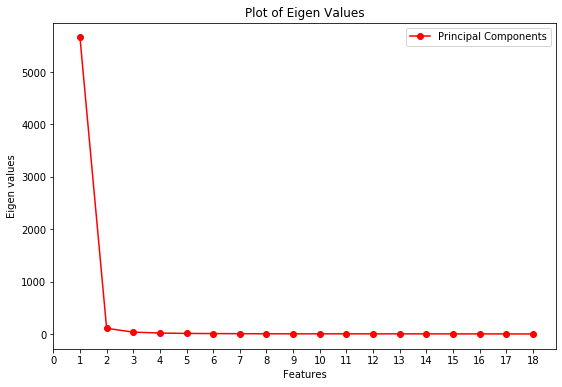

In [612]:
pca1=PCA(0.9999999999)
pca1.fit(newcasevt1)
h100=pca1.n_components_
print('h100:',h100)
vals1=pca1.explained_variance_ #get eigen values
Lj=vals1.tolist()
j=list(range(1,len(Lj)+1))
labelsp = ['Principal Components'] 

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(9,6 ))
plt.plot(j, Lj, marker='o', color='r')
plt.legend(labelsp)
plt.xlabel('Features')
plt.xticks(np.arange(0, 1+18, 1.0))
plt.ylabel('Eigen values')
plt.title('Plot of Eigen Values')

Text(0.5, 1.0, 'Plot of Increasing Ratios of Explained Variance')

<Figure size 432x288 with 0 Axes>

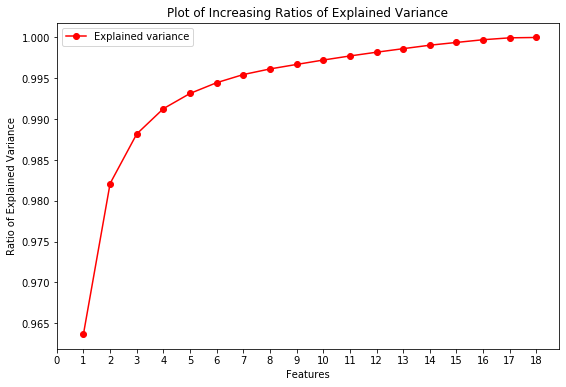

In [618]:
x=pd.DataFrame(Lj).cumsum()
RATj=x/sum(Lj)
labelsp = ['Explained variance'] 
%matplotlib inline
plt.figure(2)
plt.figure(figsize=(9,6 ))
plt.plot(j, RATj, marker='o', color='r')
plt.legend(labelsp)
plt.xlabel('Features')
plt.xticks(np.arange(0, 1+18, 1.0))
plt.ylabel('Ratio of Explained Variance')
plt.title('Plot of Increasing Ratios of Explained Variance')

Number of components, h95: 1
eigen values from x_train: 
 [5660.01]


Text(0.5, 1.0, 'Plot of x_train Eigen Values')

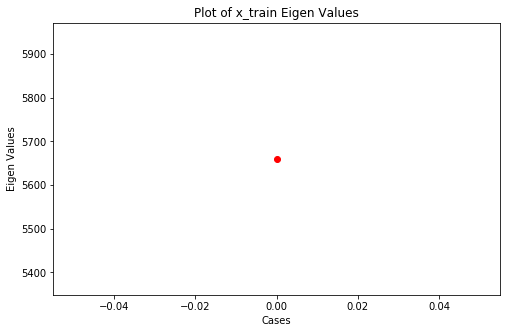

In [617]:
pca=PCA(0.95)
pca.fit(newcasevt1)
h95=pca.n_components_
print('Number of components, h95:',h95)
eigval_train=pca.explained_variance_ #get eigen values
round_eig=[round(num, 2) for num in eigval_train]
print('eigen values from x_train:','\n',round_eig)

#plot eigen values
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(1)
plt.plot(eigval_train,  marker='o', label='Eigen Values', color='r')
plt.ylabel('Eigen Values')
plt.xlabel('Cases')
plt.title('Plot of x_train Eigen Values')

For 95% variance, the number of hidden layer was estimated to be h=1

But h=2 was used as that will give a better result

In [379]:
#Define the MLP Architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant

model = Sequential()
model.add(Dense(2, activation='relu', input_dim=18, bias_initializer=Constant(value=10)))
model.add(Dense(1, activation='relu', bias_initializer=Constant(value=5)))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 38        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


Total Number of Weights and Threshold in this MLP is w=41

# Training of the MLP predictor

In [462]:
import os

In [455]:
os.environ['PYTHONHASHSEED']=str(192)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
random.seed(167)                            #To ensure reproducibility of result 
np.random.seed(199)                            #To ensure reproducibility of result 
tf.set_random_seed(88)
tf.reset_default_graph()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant

model1 = Sequential()
model1.add(Dense(2, activation='relu', input_dim=18, bias_initializer=Constant(value=10)))
model1.add(Dense(1, activation='relu', bias_initializer=Constant(value=5)))
model1.summary()

from tensorflow.keras import optimizers, losses

model1.compile(optimizer=optimizers.SGD(learning_rate=0.001, decay=1e-7), loss='mean_squared_error')
from tensorflow.keras import callbacks

# the following callback to record losses after each batch
class MyHistory1(callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.MSEtrain = []
      self.MSEtest = []
    def on_batch_end(self, batch, logs={}):
      self.MSEtrain.append(self.model.evaluate(x_train,y_train,verbose = 0))
      self.MSEtest.append(self.model.evaluate(x_test,y_test,verbose = 0))

MyMonitor1 = MyHistory1()

# Keras built-in early-stopping callback
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000, restore_best_weights=True)
Monitor = model1.fit(x_train, y_train, epochs=1000, batch_size=25, callbacks = [MyMonitor1, es], validation_data = (x_test, y_test), verbose = 2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 38        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Train on 888 samples, validate on 99 samples
Epoch 1/1000
888/888 - 1s - loss: 0.2724 - val_loss: 0.0294
Epoch 2/1000
888/888 - 1s - loss: 0.0303 - val_loss: 0.0304
Epoch 3/1000
888/888 - 1s - loss: 0.0298 - val_loss: 0.0294
Epoch 4/1000
888/888 - 1s - loss: 0.0293 - val_loss: 0.0278
Epoch 5/1000
888/888 - 1s - loss: 0.0289 - val_loss: 0.0282
Epoch 6/1000
888/888 - 1s - loss: 0.0285 - val_loss: 0.0269
Epoch 7/1000
888/888 - 1s - loss: 0.0278 - val_loss: 0.0265
Epoch 8/1000
888/888 - 1s - loss: 0.0274 - val_loss: 0.02

Epoch 123/1000
888/888 - 1s - loss: 0.0061 - val_loss: 0.0046
Epoch 124/1000
888/888 - 1s - loss: 0.0060 - val_loss: 0.0045
Epoch 125/1000
888/888 - 1s - loss: 0.0059 - val_loss: 0.0044
Epoch 126/1000
888/888 - 1s - loss: 0.0059 - val_loss: 0.0044
Epoch 127/1000
888/888 - 1s - loss: 0.0058 - val_loss: 0.0043
Epoch 128/1000
888/888 - 1s - loss: 0.0057 - val_loss: 0.0043
Epoch 129/1000
888/888 - 1s - loss: 0.0057 - val_loss: 0.0042
Epoch 130/1000
888/888 - 1s - loss: 0.0057 - val_loss: 0.0042
Epoch 131/1000
888/888 - 1s - loss: 0.0056 - val_loss: 0.0041
Epoch 132/1000
888/888 - 1s - loss: 0.0055 - val_loss: 0.0042
Epoch 133/1000
888/888 - 1s - loss: 0.0055 - val_loss: 0.0040
Epoch 134/1000
888/888 - 1s - loss: 0.0054 - val_loss: 0.0040
Epoch 135/1000
888/888 - 1s - loss: 0.0054 - val_loss: 0.0039
Epoch 136/1000
888/888 - 1s - loss: 0.0053 - val_loss: 0.0040
Epoch 137/1000
888/888 - 1s - loss: 0.0053 - val_loss: 0.0038
Epoch 138/1000
888/888 - 1s - loss: 0.0053 - val_loss: 0.0038
Epoch 13

888/888 - 1s - loss: 0.0033 - val_loss: 0.0023
Epoch 256/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0022
Epoch 257/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0022
Epoch 258/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0022
Epoch 259/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0023
Epoch 260/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0022
Epoch 261/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0024
Epoch 262/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0022
Epoch 263/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0022
Epoch 264/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0022
Epoch 265/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0025
Epoch 266/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0024
Epoch 267/1000
888/888 - 1s - loss: 0.0032 - val_loss: 0.0022
Epoch 268/1000
888/888 - 1s - loss: 0.0032 - val_loss: 0.0022
Epoch 269/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0022
Epoch 270/1000
888/888 - 1s - loss: 0.0033 - val_loss: 0.0026
Epoch 271/1000
888/888 

Epoch 388/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 389/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 390/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 391/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0023
Epoch 392/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 393/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0021
Epoch 394/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 395/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0023
Epoch 396/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0023
Epoch 397/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0027
Epoch 398/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 399/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0023
Epoch 400/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0023
Epoch 401/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 402/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 403/1000
888/888 - 1s - loss: 0.0031 - val_loss: 0.0022
Epoch 40

888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 521/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 522/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0022
Epoch 523/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0024
Epoch 524/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0023
Epoch 525/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 526/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 527/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 528/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0022
Epoch 529/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 530/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0022
Epoch 531/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 532/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 533/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 534/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0021
Epoch 535/1000
888/888 - 1s - loss: 0.0030 - val_loss: 0.0025
Epoch 536/1000
888/888 

Epoch 653/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0023
Epoch 654/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0021
Epoch 655/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0020
Epoch 656/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0021
Epoch 657/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0020
Epoch 658/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0021
Epoch 659/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0021
Epoch 660/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0022
Epoch 661/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0020
Epoch 662/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0021
Epoch 663/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0020
Epoch 664/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0022
Epoch 665/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0023
Epoch 666/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0020
Epoch 667/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0020
Epoch 668/1000
888/888 - 1s - loss: 0.0029 - val_loss: 0.0022
Epoch 66

888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 786/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 787/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0021
Epoch 788/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 789/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0021
Epoch 790/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 791/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 792/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 793/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 794/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 795/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0021
Epoch 796/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 797/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 798/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 799/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 800/1000
888/888 - 1s - loss: 0.0028 - val_loss: 0.0020
Epoch 801/1000
888/888 

Epoch 918/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0022
Epoch 919/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0019
Epoch 920/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0019
Epoch 921/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0019
Epoch 922/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0020
Epoch 923/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0020
Epoch 924/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0021
Epoch 925/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0019
Epoch 926/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0020
Epoch 927/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0020
Epoch 928/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0019
Epoch 929/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0019
Epoch 930/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0021
Epoch 931/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0020
Epoch 932/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0019
Epoch 933/1000
888/888 - 1s - loss: 0.0027 - val_loss: 0.0023
Epoch 93

In [623]:
print('Time to run the model in mins is',round((end - start)/60, 3))

Time to run the model in mins is 11.679


Mean Relative Errors of Prediction MREP

In [486]:
# Get the predicted value for boh train set and tests and compute the MREP
z_trainmodel1=model1.predict(x_train)
MREPtrainmodel1=np.average(abs(z_trainmodel1-y_train)/y_train)
z_testmodel1=model1.predict(x_test)
MREPtestmodel1=np.average(abs(z_testmodel1-y_test)/y_test)

In [487]:
print('model1, MREP_train:',round(MREPtrainmodel1,3))
print('model1, MREP_train:',round(MREPtestmodel1,3))

model1, MREP_train: 0.04
model1, MREP_train: 0.037


In [488]:
#Estimate the RMSE
RMSETrain=pd.DataFrame([MyMonitor1.MSEtrain]).transform(lambda x:x**0.5).values.reshape(36000,1)#Train set
RMSETest=pd.DataFrame([MyMonitor1.MSEtest]).transform(lambda x:x**0.5).values.reshape(36000,1)  #Test Set

Plot of RMSE

Text(0.5, 1.0, 'Plot of RMSETrain and RMSETest from the Autoencoder')

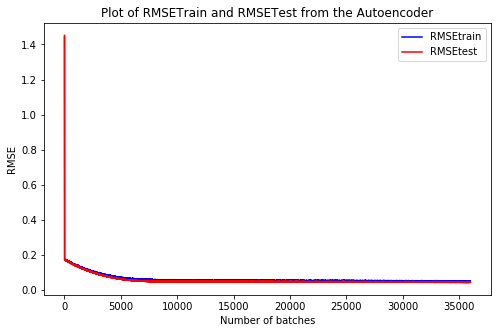

In [489]:
#plot MSE
labels=['RMSEtrain','RMSEtest']
%matplotlib inline
plt.figure(figsize=(8, 5))
plt.figure(1)
plt.plot(RMSETrain, label='RMSETrain', color='b')
plt.plot(RMSETest, label='RMSETest', color='r')
plt.legend(labels)
plt.ylabel('RMSE')
plt.xlabel('Number of batches')
plt.title('Plot of RMSETrain and RMSETest from the Autoencoder')

Plot of true values TARGt = S(t+1) and the predicted values Zt

Train Set (First 100 cases)

Text(0.5, 1.0, 'Plot of TARGt_train and Zt_train from MLP')

<Figure size 432x288 with 0 Axes>

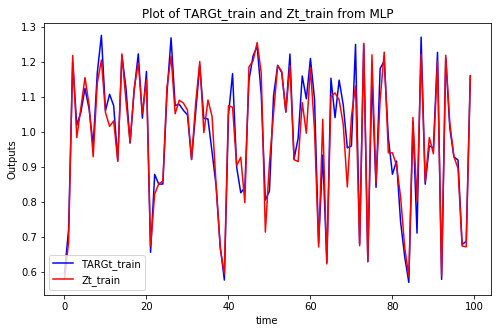

In [490]:
#plot TARGt vs Zt for the train set
labels1=['TARGt_train','Zt_train']

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(8, 5))
plt.plot(range(100), y_train[:100], color='b')
plt.plot(range(100),z_trainmodel1[:100], color='r')
plt.legend(labels1)
plt.ylabel('Outputs')
plt.xlabel('time')
plt.title('Plot of TARGt_train and Zt_train from MLP')

Test Set (First 99 cases)

Text(0.5, 1.0, 'Plot of TARGt_test and Zt_test from MLP')

<Figure size 432x288 with 0 Axes>

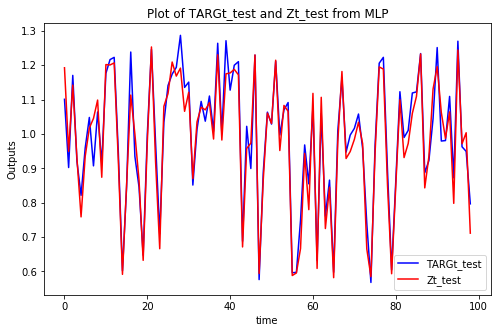

In [491]:
#plot TARGt vs Zt  for the test set
labels2=['TARGt_test','Zt_test']

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(8, 5))
plt.plot(range(99), y_test[:99], color='b')
plt.plot(range(99),z_testmodel1[:99], color='r')
plt.legend(labels2)
plt.ylabel('Outputs')
plt.xlabel('time')
plt.title('Plot of TARGt_test and Zt_test from MLP')

# Analysis of Hidden Layer Neuron

1.0 Analysing Average Impacts on Prediction

In [493]:
#Extract the hidden layer states
Htrain = pd.DataFrame(model1.layers[0](np.asarray(x_train)).numpy())

#Mean Activities for each neuron in the hidden layer
Ytrain= (Htrain.sum(axis=0))/Htrain.shape[0]

In [513]:
#Mean Activities
Ytrain

0    9.530301
1    7.651543
dtype: float32

Text(0.5, 1.0, 'Plot of Mean Activities of the hidden layer')

<Figure size 432x288 with 0 Axes>

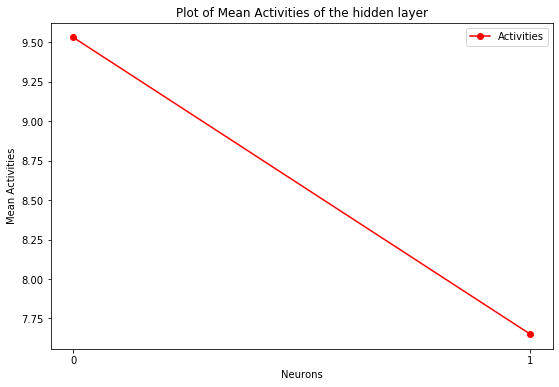

In [583]:
#Plot of Mean Activities in the hidden layer
labelsa=['Activities']

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(9,6 ))
plt.plot(Ytrain, marker='o', color='r')
plt.legend(labelsa)
plt.ylabel('Mean Activities')
plt.xlabel('Neurons')
plt.xticks(np.arange(0, 1+1, 1.0))
plt.title('Plot of Mean Activities of the hidden layer')

In [540]:
# Weights linking the neuron to the output node
weight1 = pd.DataFrame(model1.layers[1].get_weights()[0])

In [578]:
#Weights linking to output node
weight1

,0
0,-0.093761
1,-0.405396


Text(0.5, 1.0, 'Plot of Weights linking the neuron to the output node')

<Figure size 432x288 with 0 Axes>

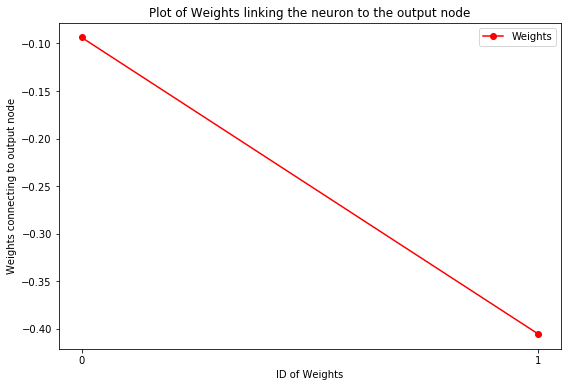

In [582]:
#Plot of Weights linking the neuron to the output node
labelsa=['Weights']

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(9,6 ))
plt.plot(weight1, marker='o', color='r')
plt.legend(labelsa)
plt.ylabel('Weights connecting to output node')
plt.xlabel('ID of Weights')
plt.xticks(np.arange(0, 1+1, 1.0))
plt.title('Plot of Weights linking the neuron to the output node')

In [585]:
# Average impact on NODj. Computed by multiplication weights by mean activity
imp1 = []
for i in range(Ytrain.shape[0]):  
    gg= pd.DataFrame(np.matrix([Ytrain.iloc[i]*weight1.iloc[i]]).flatten())  
    imp1.append(gg)
imp2=pd.concat(imp1).reset_index(drop=True)

In [586]:
imp2

,0
0,-0.893570
1,-3.101905


Text(0.5, 1.0, 'Plot of Average impact of NODj on the prediction Zt.')

<Figure size 432x288 with 0 Axes>

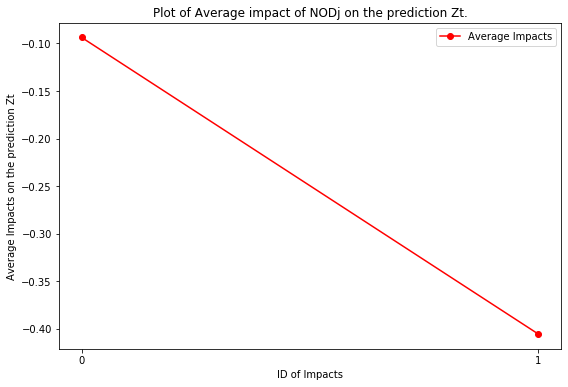

In [591]:
#Plot of Average impact of NODj on the prediction Zt.
labelsa=['Average Impacts']

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(9,6 ))
plt.plot(weight1, marker='o', color='r')
plt.legend(labelsa)
plt.ylabel('Average Impacts on the prediction Zt')
plt.xlabel('ID of Impacts')
plt.xticks(np.arange(0, 1+1, 1.0))
plt.title('Plot of Average impact of NODj on the prediction Zt.')

2.0 Analysing average impacts on hidden layer activities

In [592]:
#Mean Activities of the 18 input nodes
inp1= (x_train.sum(axis=0))/x_train.shape[0]

In [593]:
#Mean Activities of the 18 input nodes
inp1

0     1.001603
1     1.001619
2     1.001635
3     1.001287
4     1.001781
5     1.001522
6     1.001529
7     1.001881
8     1.002015
9     1.001945
10    1.001854
11    1.001894
12    1.002085
13    1.002088
14    1.002399
15    1.002457
16    1.002056
17    1.002524
dtype: float64

Text(0.5, 1.0, 'Plot of Mean Activities of the input neurons')

<Figure size 432x288 with 0 Axes>

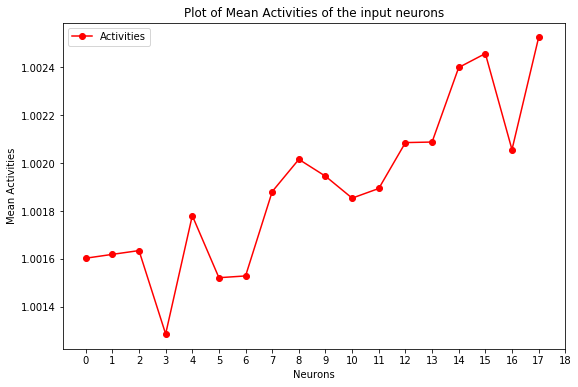

In [595]:
#Plot of Mean Activities of the input nodes
labelsa=['Activities']

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(9,6))
plt.plot(inp1, marker='o', color='r')
plt.legend(labelsa)
plt.ylabel('Mean Activities')
plt.xlabel('Neurons')
plt.xticks(np.arange(0, 1+18, 1.0))
plt.title('Plot of Mean Activities of the input neurons')

In [596]:
#All weights linking the input to the hidden layers
weight0 = pd.DataFrame(model1.layers[0].get_weights()[0])

In [597]:
#Display the weights
weight0

,0,1
0,-0.317766,0.006236
1,-0.176032,-0.281960
2,-0.021981,0.007693
3,0.464775,-0.588352
4,0.091371,-0.251485
5,0.444504,0.443909
6,-0.079488,-0.452958
7,0.215617,-0.002700
8,-0.438788,0.357164
9,0.132607,-0.219990


Text(0.5, 1.0, 'Plot of All weights linking the input to the hidden layers')

<Figure size 432x288 with 0 Axes>

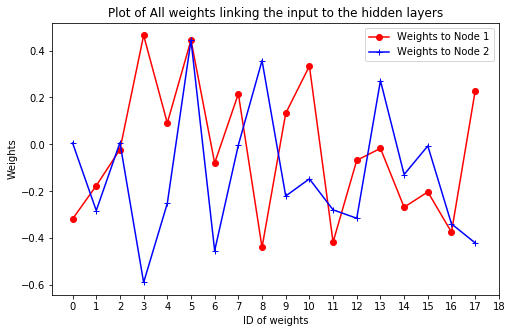

In [621]:
labelsb=['Weights to Node 1','Weights to Node 2' ]

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(8, 5))
plt.plot(weight0.iloc[:,0], marker='o', color='r')
plt.plot(weight0.iloc[:,1], marker='+', color='b')
#plt.plot(range(99),z_testmodel1[:99], color='r')
plt.legend(labelsb)
plt.ylabel('Weights')
plt.xlabel('ID of weights')
plt.xticks(np.arange(0, 1+18, 1.0))
plt.title('Plot of All weights linking the input to the hidden layers')

In [601]:
#Average impacts of input feature "s" on the key hidden neuron NOD*. F = U * X
# First Node in hidden layer
f1 = []
for i in range(inp1.shape[0]):  
    gg= pd.DataFrame(np.matrix([weight0.iloc[i,0]*inp1.iloc[i]]).flatten())  
    f1.append(gg)
ff=pd.concat(f1).reset_index(drop=True)

In [602]:
#Average impacts of input feature "s" on the key hidden neuron NOD*. F = U * X
# Second Node in hidden layer

f2 = []
for i in range(inp1.shape[0]):  
    gg= pd.DataFrame(np.matrix([weight0.iloc[i,1]*inp1.iloc[i]]).flatten())  
    f2.append(gg)
ff2=pd.concat(f2).reset_index(drop=True)

Text(0.5, 1.0, 'Plot of average impact of input feature "s" on the key hidden neuron NOD')

<Figure size 432x288 with 0 Axes>

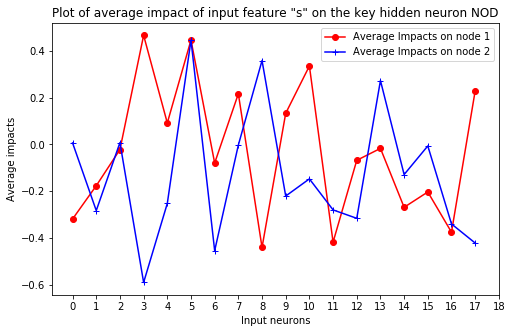

In [622]:
#For each input neuron INPs compute Fs= Us Xs 
#which is the average impact of input feature "s" on the key hidden neuron NOD*.

labelsd=['Average Impacts on node 1', 'Average Impacts on node 2']

%matplotlib inline
plt.figure(2)
plt.figure(figsize=(8, 5))
plt.plot(f1, marker='o', color='r')
plt.plot(f2, marker='+', color='b')
#plt.plot(range(99),z_testmodel1[:99], color='r')
plt.legend(labelsd)
plt.ylabel('Average impacts')
plt.xlabel('Input neurons')
plt.xticks(np.arange(0, 1+18, 1.0))
plt.title('Plot of average impact of input feature "s" on the key hidden neuron NOD')